## Low value and 2-connected components

1. Use a recursive implementation of the depth-first search given below (from previuos exercises).   
   to add computation of __low__ value, see "Lecture Notes/Course Handouts"
2. Find cutvertices
3. Partition the edges into 2-connected components (blocks)

(you can assume that the graphs are connected)

In [1]:
def DFS_with_times(G, r):
    """
    Perform DFS from root r. Result is a triple of three dictionaries:
    - dictionary mapping a vertex v to its predecessor in DFS tree (root is mapped to None).
    - dictionary mapping a vertex to its discovery (start) time
    - dictionary mapping a vertex to its finish (end) time
    """    
    global time
    time = 0
    prev = {}
    disc = {}
    # finish = {}
    prev[r] = None
    DFS_with_times_call(G, r, prev, disc) #, finish)
    return (prev, start, end)    
    
def DFS_with_times_call(G, v, prev, disc): #, finish):
    global time
    time += 1;
    disc[v] = time;
    for u in G.neighbors(v):
        if u not in prev:
            prev[u] = v
            DFS_with_times_call(G, u, prev, disc, finish)
    # time += 1;
    # finish[v] = time;

#### 1. Low value

For a vertex v: `low[v]` is the smallest `disc[x]` over all vertices which can be reached from v
using tree edges (away from root) -- red edges -- and at most one back edge -- black edge.


In the example below labels of vertices are (vertex name, discovery time, low value) and arrows indicate parent of a vertex (prev):
* `low[2]` is 1 since we can reach the root (with discovery time 1) using red edge (2, 3) and black edge (3, 1)
* `low[8]` is 3 since the vertex with the smallest discovery time we can reach in the prescribed way is 3: edges are (8, 7), (7, 9), (9, 3) and 3 has discovery time 3
* `low[10]` is 8 (its discovery time) since we can not reach any vertex with smaller discovery time using the tree edges "below" 10.


![alt text](low.png "Title")

In [2]:
def DFS_low(G, r):
    """
    Perform DFS from root r. Result is a triple of three dictionaries:
    - dictionary mapping a vertex v to its predecessor in DFS tree (root is mapped to None).
    - dictionary mapping a vertex to its discovery time
    - dictionary mapping a vertex to its low value
    """
    global time
    time = 0
    prev = {}
    disc = {}
    low = {}
    prev[r] = None
    DFS_low_call(G, r, prev, disc, low)
    return (prev, disc, low)
    
def DFS_low_call(G, v, prev, disc, low):
    global time
    time += 1;
    disc[v] = time;
    low[v] = time;
    for u in G.neighbors(v):
        if u not in prev:
            prev[u] = v
            DFS_low_call(G, u, prev, disc, low)
    for u in G.neighbors(v):
        if prev[u] == v:
            # edge (vertex) in "subtree"
            low[v] = min(low[v], low[u])
        elif u != prev[v]:
            # "back edge" and not a tree edge
            low[v] = min(low[v], disc[u])

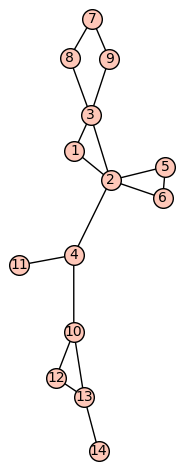

In [6]:
G = Graph({1:[2,3], 2:[3,4,5,6], 3:[8,9], 4:[10,11], 5:[6], 7:[8,9], 10:[12,13], 12:[13], 13:[14]})
G.plot()

Run algorithm from vertex 1 

In [4]:
prev, disc, low = DFS_low(G, 1)

In [5]:
low

{1: 1,
 2: 1,
 3: 1,
 8: 3,
 7: 3,
 9: 3,
 4: 7,
 10: 8,
 12: 8,
 13: 8,
 14: 11,
 11: 12,
 5: 2,
 6: 2}

Relabel vertices with triples `(vertex label, discovery time, low value)` and color tree edges red

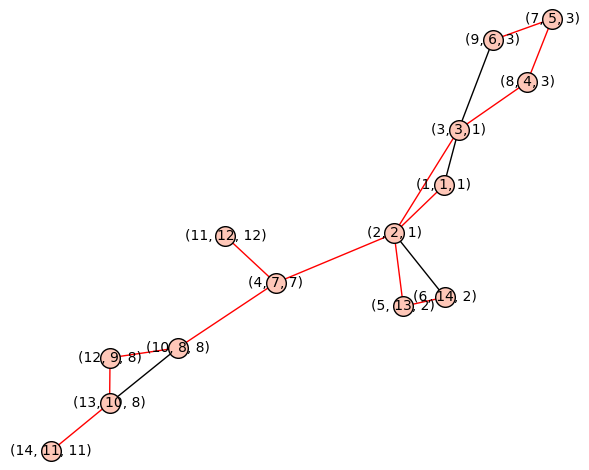

In [6]:
G1 = G.relabel(dict([(v, (v, disc[v], low[v])) for v in G.vertices(sort=False)]), inplace=False)
G1.plot(edge_colors={'red': [((u, disc[u], low[u]), (v, disc[v], low[v])) for (u, v) in prev.items() if v != None]})

#### 2. cutvertices

We can get cutvertices using the following Theorem (See Lecture Notes/Handouts).

Theorem: Let `G` be connected, undirected, simple, let `r` be the root of its `DFS` tree `T`:
* `r` is a cutvertex if is incident with ≥ 2 tree edges
* nonroot vertex `v` is a cutvertex if `v` has a son `y` so that `low[y]` ≥ `disc[v]`

In the example above, cutvertices are 2, 3, 4, 10, 13. For example 10 is a cut vertex, since its son in the tree has low value 8 which is >= than discovery time of 10, `disc[10]` == 8

Also 4 is a cutvertex since its sons (11 and 10) have low values >= 7 (7 = `disc[4]`).

The root 1 is not a cutvertex since it is incident with only one tree edge


In [11]:
def cutvertices(G):
    """
    Retuns an array of cutvertices of a connected graph G.
    """
    root = G.vertices(sort=False)[0]     # assume G is connected
    (prev, start, low) = DFS_low(G, root)
    result = []
    rootn = 0
    for v in G.vertices(sort=False):
        for u in G.neighbors(v):
            if v != root:
                if v == prev[u] and low[u] >= start[v]:
                    result.append(v)
                    break
            elif v == prev[u]:
                rootn += 1
    if rootn >= 2:
        result.append(root)
    return result

In [12]:
cutvertices(G)

[2, 3, 4, 13, 10]

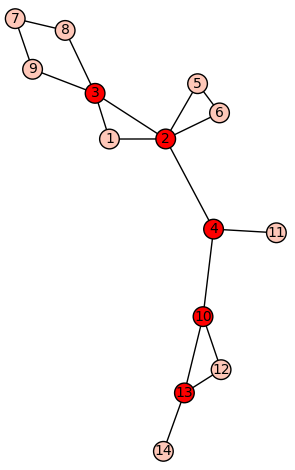

In [13]:
plot(G, vertex_colors={'red': cutvertices(G)})

#### 3. partition into blocks

Write a function partition(G) which partitions edges of G into blocks (2-connected components)

Output should be a dictionary which maps an edge of the graph into a number which represents a block. In the example above, vertices 1, 2, 3 (edges (1,2), (1,3), (2,3)) create a block. Therefore the resulting dictionary should map the pairs (1,2), (1,3), (2,3) into the same number, say 1.

In [14]:
def partition(G):
    """"
    Partitions of edges of a connected graph G into blocks.
    Returns a dictionary mapping each edge to the block (number) it belongs to.
    """
    global blocknum
    root = G.vertices(sort=False)[0]     # assume G is connected
    (prev, start, low) = DFS_low(G, root)
    blocknum = 0
    blocks = {}
    partition_call(G, root, prev, start, low, blocks, 0)
    return blocks
    
def partition_call(G, v, prev, start, low, blocks, blockn):
    global blocknum
    for u in G.neighbors(v):
        if v == prev[u]: # forward tree edge
            if low[u] >= start[v]: # cut vertex, start new block
                blocknum += 1
                blocks[(v, u)] = blocknum
                partition_call(G, u, prev, start, low, blocks, blocknum)
            else: # stay in the same block
                blocks[(v, u)] = blockn
                partition_call(G, u, prev, start, low, blocks, blockn)
        elif start[u] < start[v] and u != prev[v]: # back edge not in tree
            blocks[(u, v)] = blockn

In [15]:
partition(G)

{(10, 4): 1,
 (4, 2): 2,
 (2, 1): 3,
 (1, 3): 3,
 (2, 3): 3,
 (3, 8): 4,
 (8, 7): 4,
 (7, 9): 4,
 (3, 9): 4,
 (2, 5): 5,
 (5, 6): 5,
 (2, 6): 5,
 (4, 11): 6,
 (10, 12): 7,
 (12, 13): 7,
 (10, 13): 7,
 (13, 14): 8}

In [16]:
import random
def edge_colors(part):
    blocks = set(part.values())
    colors = [(random.random(), random.random(), random.random()) for b in blocks]
    colorblocks = [[edge for edge in part.keys() if part[edge] == b] for b in blocks]
    return dict(zip(colors, colorblocks))

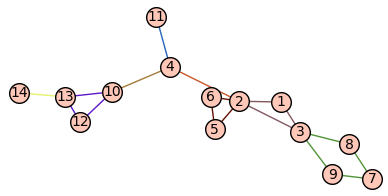

In [18]:
G.show(edge_colors = edge_colors(partition(G)))

### More examples:

In [7]:
D = graphs.DodecahedralGraph()

In [8]:
cutvertices(D)

[]

In [1]:
D1 = graphs.StarGraph(10)

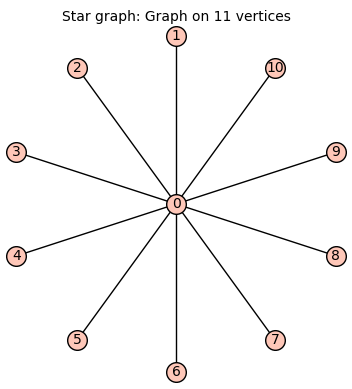

In [10]:
D1

In [11]:
cutvertices(D1)

[0]

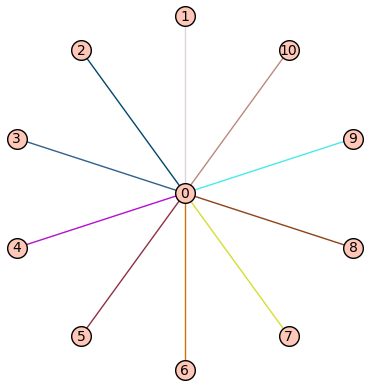

In [16]:
D1.show(edge_colors = edge_colors(partition(D1)))